#### by Alexander Guschin, 19.03.2015

#Get data from internet & unpack it

In [4]:
!mkdir data

In [5]:
!cd data && wget 'https://drivendata.s3.amazonaws.com/data/6/public/cef07265-8623-4680-b501-a5688f5babb0.zip' -O 'data.zip'

--2015-03-18 08:54:39--  https://drivendata.s3.amazonaws.com/data/6/public/cef07265-8623-4680-b501-a5688f5babb0.zip
Resolving drivendata.s3.amazonaws.com (drivendata.s3.amazonaws.com)... 54.231.17.121
Connecting to drivendata.s3.amazonaws.com (drivendata.s3.amazonaws.com)|54.231.17.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35383951 (34M) [application/zip]
Saving to: 'data.zip'

100%[======================================>] 35,383,951   111MB/s   in 0.3s   

2015-03-18 08:54:40 (111 MB/s) - 'data.zip' saved [35383951/35383951]



In [13]:
!cd data && unzip data.zip

Archive:  data.zip
 extracting: SubmissionFormat.csv    
 extracting: test_values.csv         
 extracting: train_labels.csv        
 extracting: train_values.csv        


#Load data
### Columns in "labels" are the values we need to predict

In [2]:
import pandas as pd
from pandas import DataFrame as df
from pandas import read_csv

In [4]:
train = read_csv('data/train_values.csv',sep=',',low_memory=False)
train[:1]

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN


In [5]:
test = read_csv('data/test_values.csv',sep=',',low_memory=False)
test[:1]

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,16757,c,NaN,NaN,0.053281,NaN,NaN,0.342105,0,NaN,...,NaN,NaN,NaN,NaN,a,NaN,u,NaN,NaN,a


In [6]:
labels = read_csv('data/train_labels.csv',sep=',',low_memory=False)
labels[:1]

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0


In [7]:
sampleSubmission = read_csv('data/SubmissionFormat.csv',sep=',',low_memory=False)
sampleSubmission[:1]

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,16757,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [8]:
xcols = list(train.columns)
xcols.remove('id')

ycols = list(labels.columns)
ycols.remove('id')

#Take a look
### Let's take a quick look on frequency of ones in labels (or mean, because we only have two classes=[0,1] for each column)

In [9]:
def figsize(x,y) :
    figure(figsize = (x,y))
    
from matplotlib.pyplot import *
%matplotlib inline

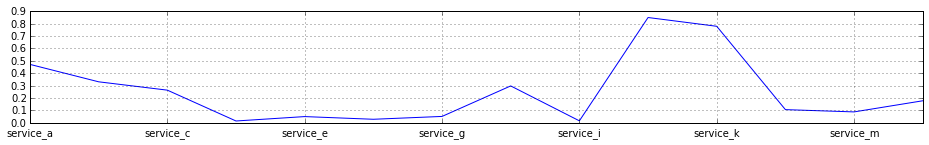

In [21]:
figsize(16,2)
(labels[ycols].sum(axis=0) / labels.shape[0]).plot()

#Preprocessing
### To use models from sklearn like RandomForestClassifier, LinearSVC, LogisticRegression, KNeighborsClassifier we need to replace categorical variables with numbers. For this purpose we use LabelEncoder

In [11]:
import logging
reload(logging)
logging.basicConfig(format = u'[%(asctime)s]  %(message)s', level = logging.INFO)
logging.info('')

[2015-03-18 13:41:18,678]  


In [12]:
logging.info('')

from sklearn import preprocessing
import numpy as np

train2 = train.copy().fillna(-1)
test2  = test.copy().fillna(-1)

le = preprocessing.LabelEncoder()

for c in list(train2.columns):
    if c[0] == 'c' :
        
        le.fit(np.concatenate([train2[c].values,test2[c].values]))
        train2[c] = le.transform(train2[c].values)
        test2 [c] = le.transform(test2 [c].values)

le.fit(train2.release.values)
train2.release = le.transform(train2.release.values)
test2.release  = le.transform(test2.release.values)
        
logging.info('')

[2015-03-18 13:41:21,600]  
[2015-03-18 13:44:16,377]  


#Cross-validation (Holdout)
###Let's ran simple RandomForest and see what we can do

In [13]:
from sklearn.cross_validation import train_test_split
xtrain, xcv, ytrain, ycv = train_test_split(train2[xcols].fillna(-1), 
                                            labels[ycols], 
                                            test_size=0.25, 
                                            random_state=0)

In [14]:
logging.info('')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

#to speed up calculations, you can set n_jobs to number logical cores-1
#if n_jobs == number of logical cores, be ready to experience freeze
rf = RandomForestClassifier(n_estimators=50, n_jobs = 1)
rf_imp = []
loss = []

for i,c in enumerate(ycols):
    rf.fit(xtrain, ytrain[:,i])
    prediction = rf.predict_proba(xcv)[:,1]
    loss += [log_loss(ycv[:,i], prediction, eps=1e-16)]
    
    rf_imp += [rf.feature_importances_]

print np.mean(loss)

logging.info('')

[2015-03-18 13:44:18,075]  
[2015-03-18 13:44:56,249]  


0.316376210956


In [15]:
train2[:1]

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,0,-1,-1,0.025449,-1,-1,0.368421,-1,-1,...,0,0,0,0,1,0,17,0,0,0


#Submission

In [16]:
logging.info('')

submission = sampleSubmission.copy()

for i,c in enumerate(ycols):
    rf.fit(train2[xcols].fillna(-1), labels[c])
    prediction = rf.predict_proba(test2[xcols])[:,1]
    submission[c] = prediction
    
logging.info('')

submission[:1]

[2015-03-18 13:44:56,282]  
[2015-03-18 13:45:58,950]  


,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,16757,0.32,0.32,0.2,0.1,0.08,0,0.02,0.34,0.02,0.76,0.64,0.14,0.02,0.52


In [45]:
!mkdir submissions

In [17]:
submission.to_csv('submissions/01.csv',index=False)

#Futher Ideas
###first of all, let's see how many Not-A-Number values do we have

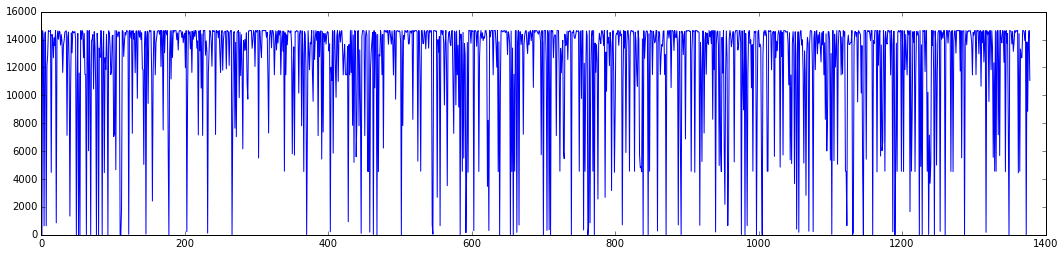

In [18]:
figsize(18,4)
plot(pd.isnull(train).sum(axis=0))

###We can see that too many features have very huge percentage of NaNs. So it could be a good idea to remove some unimportant features. For that we can use Random Forest's feedback about feature importances. Every time we ran RF we were saving imps in "rf_imp" to use them later. Now let's plot histogram of feature importances.

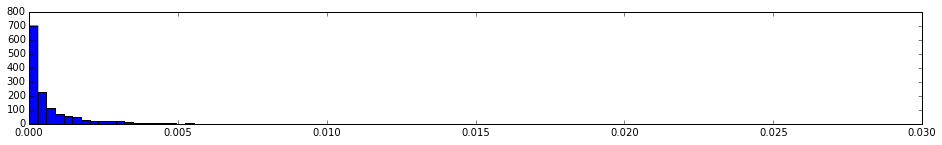

In [19]:
figsize(16,2)
imp = sum(rf_imp)/len(rf_imp)
hist(imp,bins=100) ;

###It is worth trying to remove features with importance < 0.001 and ran RandomForest on these features only ;-)

In [20]:
from __future__ import division
sum(imp > .001)/imp.shape[0]

0.21407837445573294

###In that case we will use only about 22% of them, so randomForest will execute faster and results can be much better